In [4]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
from random import shuffle
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.callbacks import *
from imgaug import augmenters as iaa
from albumentations import Compose, RandomRotate90, Transpose, Flip, OneOf, CLAHE, IAASharpen, IAAEmboss, RandomBrightnessContrast, JpegCompression, Blur, GaussNoise, HueSaturationValue, ShiftScaleRotate, Normalize
import imgaug as ia
from kerascv.model_provider import get_model as kecv_get_model
from keras.regularizers import l2
print(os.listdir(r"C:\Users\msanj\cancer"))
import shutil,math

['best_xceptoion1.h5', 'cancer1', 'last_xception1.h5', 'last_xception2.h5', 'model.h5', 'model1.h5', 'results_cnn1.csv', 'results_seq1.csv', 'results_seq2.csv', 'results_seqcnn.csv', 'sample_submission.csv', 'sequential1.h5', 'sequential2.h5', 'sequentialcnn.h5', 'test', 'test1', 'test_20', 'train', 'train_labels.csv', 'train_labels_50.csv']


In [5]:
img_size_in = 224

In [6]:

df_train = pd.read_csv(r"C:\Users\msanj\cancer\train_labels.csv")
id_label_map = {k:v for k,v in zip(df_train.id.values, df_train.label.values)}
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1].replace('.tif', '')

In [8]:
labeled_files = glob(r'C:\Users\msanj\cancer\train\*.tif')
test_files = glob(r'C:\Users\msanj\cancer\test\*.tif')

In [9]:
train, val = train_test_split(labeled_files, test_size=0.1, random_state=101010)

In [10]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def do_train_augmentations():
    return Compose([
        RandomRotate90(p=0.5),
        Transpose(p=0.5),
        Flip(p=0.5),
        OneOf([CLAHE(clip_limit=2),
              IAASharpen(),
              IAAEmboss(),
              RandomBrightnessContrast(),
              JpegCompression(),
              Blur(),
              GaussNoise()],
              p=0.5),
        HueSaturationValue(p=0.5),
        ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=45, p=0.5),
        Normalize(p=1)])


def do_inference_aug():
    return Compose([Normalize(p=1)], p=1)
def data_gen(list_files, id_label_map_in, batch_size_in, img_size_in, aug_funtion):
    aug = aug_funtion()
    
    while True:
        shuffle(list_files)
        for block in chunker(list_files, batch_size_in):

            X = [cv2.resize(cv2.imread(x), (img_size_in, img_size_in)) for x in block]
            X = [aug(image=x)['image'] for x in X]

            Y = [id_label_map_in[get_id_from_file_path(x)] for x in block]

            yield np.array(X), np.array(Y)

In [11]:
def create_model(input_shape, n_out):
    inp_mask = Input(shape=input_shape)
    net = kecv_get_model("fdmobilenet_w3d4", pretrained=True)
    net.name = 'shufflenet'

    x = net(inp_mask)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.25)(x)
    out = Dense(n_out, activation="sigmoid")(x)
    model = Model(inputs=inp_mask, outputs=[out])
    model.summary()    
    return model

In [12]:
model = create_model(input_shape=(img_size_in, img_size_in, 3), n_out=1)



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
shufflenet (Model)           (None, 1000)              1845112   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               512512    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0  

In [13]:
import shutil,math
def step_decay(epoch):
    initial_lrate=1e-4
    drop=0.6
    epochs_drop = 3.0
    lrate= initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

In [14]:
h5_path = r'C:\Users\msanj\cancer\model.h5'
checkpoint = ModelCheckpoint(h5_path, 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)

lrsched = LearningRateScheduler(step_decay,verbose=1)

callbacks = [checkpoint,lrsched]

In [12]:
batch_size=32
for layer in model.layers:
    layer.trainable = False
    
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True
model.layers[-7].trainable = True


model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(lr=1e-3),
    metrics=['acc'])

history = model.fit_generator(
    data_gen(train, id_label_map, batch_size,  img_size_in, do_train_augmentations),
    validation_data=data_gen(val, id_label_map, batch_size,img_size_in,do_inference_aug),
    epochs=2, verbose=1,
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/2
6188/6188 [==============================] - 14299s 2s/step - loss: 0.2943 - acc: 0.8822 - val_loss: 0.1869 - val_acc: 0.9306
Epoch 2/2
6188/6188 [==============================] - 14086s 2s/step - loss: 0.2415 - acc: 0.9073 - val_loss: 0.1875 - val_acc: 0.9320


In [15]:
temp=model
temp.save_weights (r'C:\Users\msanj\cancer\model1.h5')   

In [16]:
t1 = temp.load_weights(r'C:\Users\msanj\cancer\model1.h5')

In [18]:
test_files = glob('../input/histopathologic-cancer-detection/test1/*.tif')
batch_size=32
t1 = temp.load_weights(r'C:\Users\msanj\cancer\model1.h5')

In [19]:
preds = []
ids = []

for batch in chunker(test_files, batch_size):
    X = [preprocess_input(cv2.resize(cv2.imread(x),(img_size_in,img_size_in))) for x in batch]
    ids_batch = [get_id_from_file_path(x) for x in batch]
    X = np.array(X)
    preds_batch = ((t1.predict(X).ravel()*temp.predict(X[:, ::-1, :, :]).ravel()*temp.predict(X[:, ::-1, ::-1, :]).ravel()*temp.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    preds += preds_batch
    ids += ids_batch

In [20]:
df = pd.DataFrame({'id':ids, 'label':preds})
df.to_csv("baseline_FD-MobileNet.csv", index=False)
df.head()

,id,label


In [21]:
temp.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
shufflenet (Model)           (None, 1000)              1845112   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               512512    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0   

In [22]:
in_size=[224, 224, 3]
print(temp.layers[0])

In [39]:
from keras.preprocessing import image
IMG_SIZE=224
batch_holder = np.zeros((20, IMG_SIZE, IMG_SIZE, 3))
img_dir=r'C:\Users\msanj\cancer\test1'
for i,img in enumerate(os.listdir(img_dir)):
  img = image.load_img(os.path.join(img_dir,img), target_size=(IMG_SIZE,IMG_SIZE))
  batch_holder[i, :] = img

In [40]:
result=temp.predict(batch_holder)

In [51]:
print(result)

[[0.6795871 ]
 [0.8265652 ]
 [0.7465615 ]
 [0.5225766 ]
 [0.6490973 ]
 [0.63613683]
 [0.93828523]
 [0.70915675]
 [0.86380756]
 [0.8677182 ]
 [0.85363007]
 [0.9016973 ]
 [0.7774416 ]
 [0.94041616]
 [0.55491906]
 [0.36015016]
 [0.5610151 ]
 [0.7810427 ]
 [0.6809305 ]
 [0.6939317 ]]


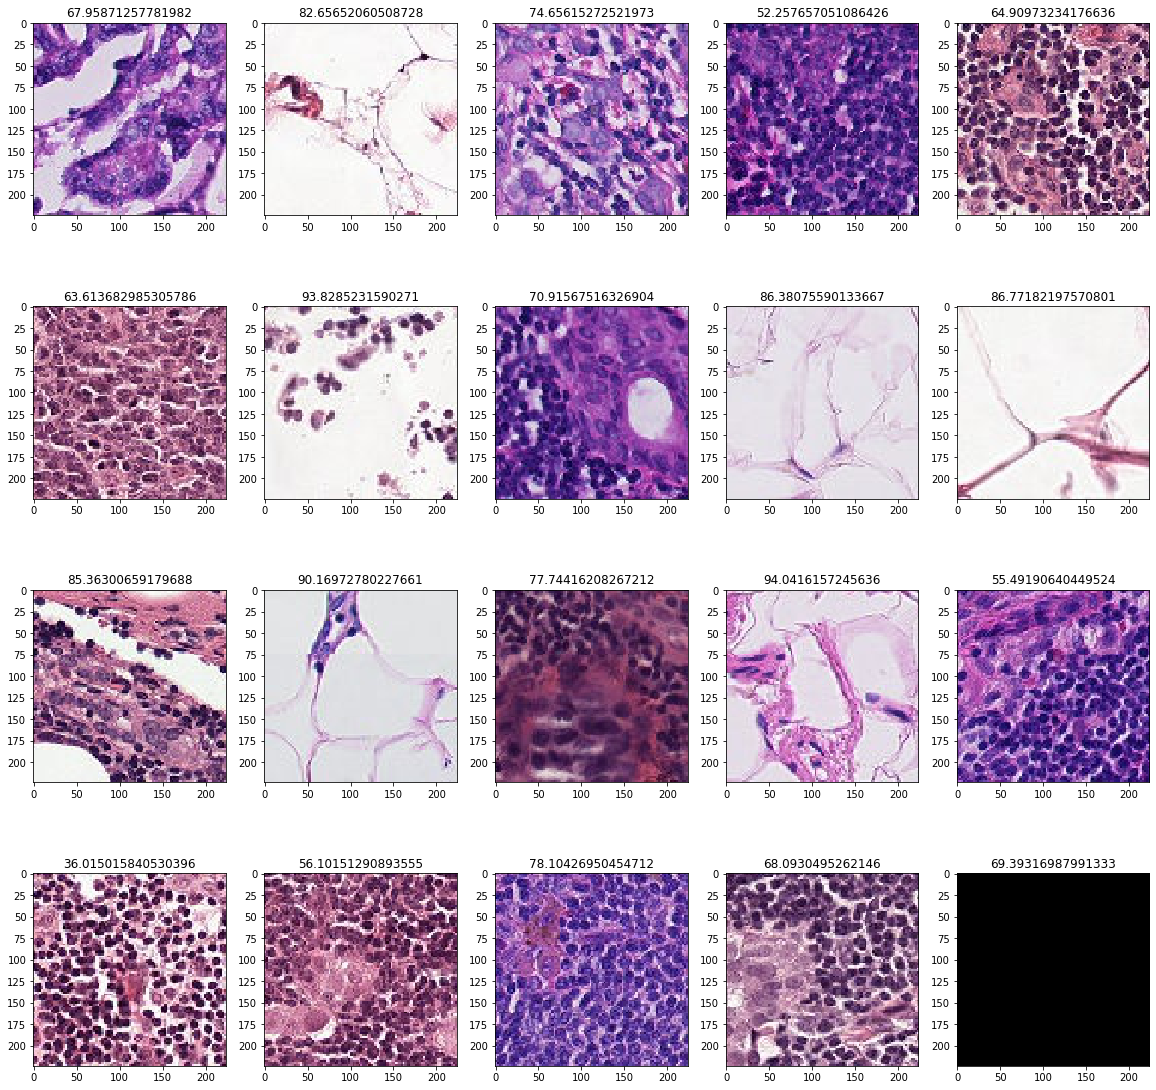

In [42]:
import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import load_model
from keras.preprocessing import image



fig = plt.figure(figsize=(20, 20))
 
for i,img in enumerate(batch_holder):
  fig.add_subplot(4,5, i+1)
  plt.title((result[i][0])*100)
  plt.imshow(img/256.)
  
plt.show()